In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import numpy as np
import torch
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import  torch.nn as nn
import torch.nn.functional as F
rseed = 42
np.random.seed(rseed)
torch.manual_seed(rseed)
gpu_id = '0'
from joblib import Parallel, delayed
os.environ['CUDA_VISIBLE_DEVICES']=gpu_id
os.environ['JOBLIB_TEMP_FOLDER'] = '/ksozykinraid/data/tmp/'
from time import time
import torch 
import pandas as pd
import glob2
import json
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from utils import *
from datasets import *
from layers import *

## Datasets

In [3]:
data_root = '/ksozykinraid/data/sensors/'
data_fnzip =  "%s/%s" % (data_root , 'PAMAP2_Dataset.zip')
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip'

In [4]:
if not os.path.exists(data_fnzip[:-4]):
    !curl -L $data_url -o $data_fnzip
    !unzip $data_fnzip -d $data_root

In [5]:
path2subjets = sorted(glob2.glob('%s/PAMAP2_Dataset/Protocol/*.dat' % data_root))

In [6]:
def pamap_columns():
    """
        https://github.com/NLeSC/mcfly-tutorial/blob/master/utils/tutorial_pamap2.py
    """
    axes = ['x', 'y', 'z']
    IMUsensor_columns = ['temperature'] + \
        ['acc_16g_' + i for i in axes] + \
        ['acc_6g_' + i for i in axes] + \
        ['gyroscope_' + i for i in axes] + \
        ['magnometer_' + i for i in axes] + \
        ['orientation_' + str(i) for i in range(4)]
    columns = ["timestamp", "activityID", "heartrate"] + ["hand_" + s
                                                         for s in IMUsensor_columns] \
        + ["chest_" + s for s in IMUsensor_columns] + ["ankle_" + s
                                                       for s in IMUsensor_columns]
    return columns

In [7]:
#overlap = []
#for i in tqdm(range(n_subjects)):
#    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
#    subject.columns = pamap_columns()
#    overlap.append(subject['activityID'].values)
#overlap = np.hstack(overlap)
#overlap = [num2label[e] for e in np.unique(overlap)[1:]]

In [8]:
demo_activities = "lying,sitting,standing,walking".split(',')

In [9]:
subset_activities = ['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic walking',
 'ascending stairs',
 'descending stairs',
 'vacuum cleaning',
 'ironing',
 'rope jumping']

In [10]:
all_columns = pamap_columns()

In [11]:
input_channels = len(useful_columns_onehand[:-1])

In [12]:
win_size = 64
step = 32

In [13]:
demo_mode = True

In [14]:
activities = demo_activities if demo_mode else  subset_activities

In [15]:
subject = pd.read_csv(path2subjets[0],header=None,sep=' ')
subject.columns = pamap_columns()

In [16]:
subjects = []
n_subjects = len(path2subjets)
for i in tqdm(range(n_subjects)):
    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
    subject.columns = pamap_columns()
    subject = subject[subject['activityID'].isin([label2num[a] for a in activities])]
    subject['activityID'] =  subject['activityID'].apply(lambda a: activities.index(num2label[a]))
    subject = subject[useful_columns]
    if len(subject) > 0:
        subject = subject.fillna(0)
        #subject = subject.iloc[:min_len]
        subjects.append(subject)

100%|██████████| 9/9 [00:24<00:00,  2.75s/it]


In [17]:
subjects[0].head()

,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_gyroscope_x,hand_gyroscope_y,hand_gyroscope_z,hand_magnometer_x,hand_magnometer_y,hand_magnometer_z,chest_acc_16g_x,...,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z,ankle_gyroscope_x,ankle_gyroscope_y,ankle_gyroscope_z,ankle_magnometer_x,ankle_magnometer_y,ankle_magnometer_z,activityID
2928,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,0.124482,...,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,0
2929,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,0.200711,...,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,0
2930,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,0.270277,...,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,0
2931,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,0.236737,...,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,0
2932,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,0.352225,...,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,0


In [18]:
num_classes = len(activities)

In [19]:
train_dataset = pamap2Dataset(subjects,fold='train',
                              num_classes=num_classes,
                              useful_columns = useful_columns_onehand,
                              win_size=win_size,step=step)
val_dataset = pamap2Dataset(subjects,fold='val',
                            num_classes=num_classes,
                            useful_columns = useful_columns_onehand,
                            win_size=win_size)
test_dataset = pamap2Dataset(subjects,fold='test',
                             num_classes=num_classes,
                             test_subject = 6,
                             useful_columns = useful_columns_onehand,
                             win_size=win_size,step=step)

100%|██████████| 8/8 [00:22<00:00,  2.82s/it]


In [20]:
useful_columns[:-1] == data_columns

True

In [21]:
len(train_dataset),len(val_dataset),len(test_dataset)

(15502, 1662, 3041)

In [22]:
#train_lb = np.argmax(train_dataset.labels,-1)
#val_lb = np.argmax(val_dataset.val_labels,-1)

In [23]:
#plt.hist(train_lb)

# Models

In [24]:
class Conv1DNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(256*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [25]:
class MultiSincNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device)
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(7936,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [26]:
class Conv1DLstmNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=512,batch_first=True)
        self.fc1 = nn.Linear(8*win_size*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
        )
        

        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        #print(features.shape)
        return self.classifier(features)

In [27]:
class MultiSincLstmNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device)
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=512,batch_first=True)
        self.fc1 = nn.Linear(7936*2,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        

                
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(features)

## Debug

In [28]:
device = 'cpu'
batch_size = 1
model = Conv1DNet().to(device)
dummy_batch = train_dataset.train_data[:batch_size]
dummy_batch = torch.tensor(dummy_batch).transpose(2,1)
prediction = model(dummy_batch.to(device))
del model
del dummy_batch
print(prediction.shape)
del prediction
torch.cuda.empty_cache()

torch.Size([1, 4])


## Experiments

In [29]:
num_epochs = 50
verbose = 5
batch_size = 1024
device = "cuda"

In [30]:

def compute_loss(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    reference = torch.argmax(reference,dim=-1).to(torch.long)
    prediction = prediction.log_softmax(dim=-1)
    loss = nn.NLLLoss()(prediction,reference)
    return loss

In [31]:
def compute_acc(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    prediction = torch.argmax(prediction.log_softmax(dim=-1),dim=-1)
    reference = torch.argmax(reference,dim=-1)
    return (reference == prediction).to(torch.float32).mean()

In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [33]:
model = Conv1DNet().to(device)
#model = Conv1DLstmNet().to(device)
#model = MultiSincNet(device=device).to(device)
#model = MultiSincLstmNet(device=device).to(device)

In [34]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

In [35]:
best_acc = -1
best_loss =999999999
sPATH = ''
fmt_str = '/ksozykinraid/har-models/%s_onehand_%dclass_winsize%d_%.4f.pth'

In [36]:
from collections import  defaultdict
report  = defaultdict(list)

In [37]:
from IPython import display

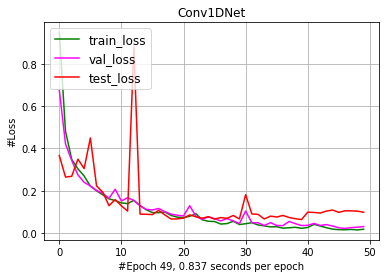

49	Training:
	Loss:	0.01794
	ACC:	0.99439
49	Validation:
	BEST VAL loss:	0.02206
	Loss:	0.03045
	val ACC:	0.98977
49	Testing:
	Loss:	0.03277
	test ACC:	0.97632




In [38]:
for epoch in range(num_epochs):
    train_loss = train_acc = train_batches = 0 
    train_acc_fixed = 0
    model.train()
    y_true,y_pred = [],[]
    start = time.time()
    for batch in train_loader:
        
        data,reference = batch
        data = data.transpose(2,1).to(device)
        #print(data.shape)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    
    with torch.no_grad():
        train_acc += compute_acc(y_true, y_pred).cpu().numpy()
    
    val_loss = val_acc = val_batches = 0
    val_acc_fixed = 0
    #model.train(False)
    model.eval()
    y_true,y_pred = [],[]
    for batch in val_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            val_loss += loss.item()
            
            val_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        val_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #val_acc = (val_acc / val_batches)
    val_loss = (val_loss / val_batches)
    
    y_true,y_pred = [],[]
    test_loss = test_acc = test_batches = 0
    for batch in test_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        #print(len(reference),len(prediction))
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            test_loss += loss.item()
            
            test_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        test_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #test_acc = (test_acc / test_batches)
    
    test_loss = (test_loss / test_batches)
    
    
    
    if val_loss < best_loss:
        best_loss = val_loss
        if sPATH != '' and os.path.exists(sPATH):
            os.remove(sPATH)
        sPATH = fmt_str % (model.__class__.__name__,num_classes,win_size,best_loss)
        torch.save(model.state_dict(),sPATH)
        if best_acc > 94:
            print("Early Stopping")
            break
    report['train_loss'].append(train_loss / train_batches)
    report['val_loss'].append(val_loss)
    report['test_loss'].append(test_loss)
    finish = time.time()
    time_epoch = finish-start    
    display.clear_output(wait=True)
    fig = plt.Figure(figsize=(20,20),facecolor='white')
    plt.plot(report['train_loss'],color='green',label='train_loss')
    plt.plot(report['val_loss'],color='magenta',label='val_loss')
    plt.plot(report['test_loss'],color='red',label='test_loss')
    plt.xlabel("#Epoch %d, %.3f seconds per epoch" % (epoch,time_epoch))
    plt.ylabel("#Loss")
    plt.title(model.__class__.__name__)
    legend(loc=2, prop={'size': 12})
    plt.grid()
    plt.show()
    
    print("%d\tTraining:" % (epoch))
        
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tACC:\t%.5f" % (train_acc))
    print("%d\tValidation:" % (epoch))
    print("\tBEST VAL loss:\t%.5f" % best_loss)
    print("\tLoss:\t%.5f" % val_loss)
    print("\tval ACC:\t%.5f" % val_acc)
    print("%d\tTesting:" % (epoch))
    print("\tLoss:\t%.5f" % (test_loss / test_batches))
    print("\ttest ACC:\t%.5f" % test_acc)
    print('\n')
    
    
    if epoch  % verbose == 0 or epoch == num_epochs - 1:
        pass

In [39]:
model.load_state_dict(torch.load(sPATH))
model.eval();

## Metrics

In [40]:
reference.shape,prediction.shape

(torch.Size([993, 4]), torch.Size([993, 4]))

In [41]:
y_true_np = torch.argmax(y_true,dim=-1).detach().cpu().numpy()
y_pred_np = torch.argmax(y_pred.log_softmax(dim=-1),dim=-1).detach().cpu().numpy()

In [42]:
np.unique(y_pred_np) == np.unique(y_true_np) 
assert len(y_true_np) == len(test_dataset)

In [43]:
n_conf = 5 if demo_mode else num_classes + 1

In [44]:
creport = pd.DataFrame((classification_report(y_true_np,y_pred_np,output_dict=True)))
acc = accuracy_score(y_true_np,y_pred_np)
fm_score = []
for i in range(n_conf):
    try:
        fm_score.append(creport[str(i)]['f1-score'])
    except:
        pass

In [45]:
np.mean(fm_score)

0.9699967039150574

In [46]:
# rope jumping corrupting color scheme
cm  = create_conf_matrix(y_true_np,y_pred_np,n_classes=len(activities))
cmdf = pd.DataFrame(cm)
cmdf.columns = activities
cmdf.index = activities

In [47]:
cmdf

,lying,sitting,standing,walking
lying,353,4,17,0
sitting,31,794,8,0
standing,0,6,1025,3
walking,0,0,3,797


In [48]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.jet):
    """
        https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
    """
    plt.figure(figsize=(20,20),facecolor='white')
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title("%s" % (model.__class__.__name__))
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name, fontsize=12)
    plt.xlabel(df_confusion.columns.name, fontsize=12)

<Figure size 1440x1440 with 0 Axes>

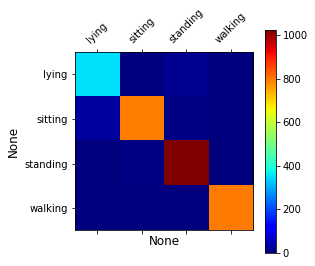

In [49]:
plot_confusion_matrix(cmdf)

In [50]:
print("%s\t%d\t%.4f\t%.4f" %(model.__class__.__name__,num_classes,np.mean(fm_score),acc))

Conv1DNet	4	0.9700	0.9763


## History of best Results (win_size = 256)

% model.__class__.__name__,num_classes,np.mean(fm_score),acc)
<br>
<br>
<pre>
Conv1DNet           12	0.8437	0.9380
MultiSincNet	    12	0.8635	0.9527
Conv1DLstmNet       12	0.9188	0.9318
MultiSincLstmNet	12	0.9219	0.9362
</pre>
<br>
<pre>
Conv1DNet	        4	0.9967	0.9960
MultiSincNet        4	0.9837	0.9855
Conv1DLstmNet	   4	0.9848	0.9868
MultiSincLstmNet	4	0.9934	0.9921
</pre>

## some inference

In [51]:
def transform_csv(path):
    new_col_names = ["time", "hand_accelerometer", "hand_magnetometer", "hand_gyroscope", "ankle_accelerometer", "ankle_magnetometer", "ankle_gyroscope", "chest_accelerometer","chest_magnetometer", "chest_gyroscope"]
    replaced_cols = ["time", "hand_accelerometer", "hand_gyroscope", "hand_magnetometer", "ankle_accelerometer", "ankle_gyroscope","ankle_magnetometer",  "chest_accelerometer", "chest_gyroscope","chest_magnetometer"]
        
    def column_transform(data,col_name):
        if col_name != "time":
            new = data[col_name].str.replace(")","").str.replace("(","").str.replace(" ","").str.split(",", n = 2, expand = True) 
            data[col_name + "_x"] = new[0]
            data[col_name + "_y"] = new[1]
            data[col_name + "_z"] = new[2]
            data.drop(columns =[col_name], inplace = True) 
        return data
    
    data = pd.read_csv(path)
    
    data = data.rename(index=str,columns = dict(zip(list(data.columns),new_col_names)))
    
    data = data[replaced_cols]
    


    for col in data.columns:
        data = column_transform(data, col)
    return data

In [72]:
data = transform_csv('/ksozykinraid/src/real_data2.csv')
data = data.iloc[:,:len(data_columns_onehand)+1]
data = data.drop(['time'],1)
data = data.values.astype('float32')

In [73]:
data.shape

(119, 9)

In [87]:
batch = []
model.eval()
for window in sliding_window(data,win_size=win_size,step=16):
    batch.append(window)
batch = torch.tensor(np.array(batch)).to(device)
print(batch.shape)
batch = batch.transpose(2,1)

torch.Size([4, 64, 9])


In [88]:
batch.shape

torch.Size([4, 9, 64])

In [89]:
torch.argmax(model(batch).softmax(-1),-1)

tensor([2, 2, 2, 3], device='cuda:0')

In [90]:
preds = [activities[int(e)] for e in torch.argmax(model(batch).softmax(-1),-1)]
classes, counts = np.unique(preds,return_counts=True)

In [91]:
preds

['standing', 'standing', 'standing', 'walking']

In [92]:
final_predcit = classes[np.argmax(counts)]

In [93]:
final_predcit 

'standing'

In [61]:
assert

SyntaxError: invalid syntax (<ipython-input-61-54b8a87cebf1>, line 1)

## Visualisation  feature-maps after SincLayer

In [ ]:
device = 'cuda'
fs = 100
model = MultiSincLstmNet(device=device).to(device)
sPATH = '/ksozykinraid/har-models/MultiSincLstmNet_12class_0.1178.pth'
model.load_state_dict(torch.load(sPATH))
model.eval();
N_filt=12

In [ ]:
with torch.no_grad():
    params = torch.stack(list(model.sincconv.parameters())).cpu().numpy()
    filt_b1,filt_band = params*fs
    min_freq=1.0;
    min_band=10.0;
    filt_beg_freq=np.abs(filt_b1)+min_freq/fs
    filt_end_freq=filt_beg_freq+(np.abs(filt_band)+min_band/fs)

In [ ]:
with torch.no_grad():
    sample_id = 0
    for viz_batch  in test_loader:
        viz_data,reference = viz_batch
        viz_data = viz_data.transpose(2,1).to(device)
        viz_sinc = model.sincconv(viz_data).cpu().numpy()[sample_id]
        viz_data = viz_data.cpu().numpy()[sample_id]
        viz_sinc = viz_sinc.reshape([N_filt,input_channels,-1]).transpose(1,0,2)
        break

In [ ]:
"""
https://stackoverflow.com/a/38251497
https://stackoverflow.com/a/28222930
"""
from itertools import cycle
cycol = cycle('bgrcmk')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [ ]:
with torch.no_grad():
    k =  10## channel_id
    n_viz_samples  = 128
    figure(facecolor='white',figsize=(25,25))
    for i in range(N_filt+1):
        plt.subplot(4,4,i+1)
        if i == 0:
            plot(viz_data[k][:n_viz_samples],color='green')
            title(subjects[0].columns[k-1])
        else:
            title("%s, \n %d channel" %(subjects[0].columns[k-1],i-1))
            plot(viz_sinc[k][i-1][:n_viz_samples],color=next(cycol))
            